# Satellite-Derived Bathymetry (SDB): Model Inference

This is the final stage of the SDB workflow: applying the trained Machine Learning model to a full satellite scene to generate a continuous bathymetric map.

**Workflow:**
1.  **Load Artifacts:** Import the trained XGBoost model (.pkl) and the target satellite raster (e.g., corrected Sentinel-2 or Embeddings).
2.  **Data Transformation:** Flatten the 3D raster data (Height, Width, Bands) into a 2D matrix (Pixels, Features) suitable for model inference.
3.  **Inference:** Predict depth values for every valid water pixel.
4.  **Reconstruction:** Reshape the 1D prediction array back into the original 2D spatial dimensions.
5.  **Export:** Save the predicted bathymetry map as a GeoTIFF with appropriate metadata (CRS, transform, nodata).
6.  **Visualization:** Display the final depth map for visual inspection.

**Output:** A GeoTIFF file representing estimated water depth (in meters).

In [1]:
import os
import joblib
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.plot import show

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# ==========================================
# 1. CONFIGURATION
# ==========================================

# --- Input Paths ---
# The raster to predict on (Must match the features used in training!)
RASTER_PATH = r'data\corrected\corrected_s2_giliketapang_2018-05-31.tif'

# The trained model file
MODEL_PATH = r'model\xgboost_sdb_model.pkl'

# --- Output Paths ---
OUTPUT_DIR = r'output'
OUTPUT_FILENAME = 'SDB_Gili_Ketapang_2018_embeddings.tif'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Input Raster: {RASTER_PATH}")
print(f"Model: {MODEL_PATH}")
print(f"Output Target: {os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)}")

Input Raster: data\corrected\corrected_s2_giliketapang_2018-05-31.tif
Model: model\xgboost_sdb_model.pkl
Output Target: output\SDB_Gili_Ketapang_2018_embeddings.tif


In [3]:
# ==========================================
# 2. LOAD DATA & MODEL
# ==========================================
print("Loading assets...")

# 1. Load Model
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at: {MODEL_PATH}")

sdb_model = joblib.load(MODEL_PATH)
print(f"Model loaded: {type(sdb_model).__name__}")

# 2. Load Raster Data
if not os.path.exists(RASTER_PATH):
    raise FileNotFoundError(f"Raster file not found at: {RASTER_PATH}")

with rio.open(RASTER_PATH) as src:
    # Read all bands -> Shape: (Bands, Height, Width)
    raster_data = src.read()
    raster_meta = src.profile.copy()
    
    # Get dimensions
    n_bands, height, width = raster_data.shape
    
    # Create a mask for valid pixels (assuming 0 is nodata/land)
    # We check if *any* band has a non-zero value
    valid_mask = np.any(raster_data != 0, axis=0)

print(f"Raster loaded. Dimensions: {width}x{height}, Bands: {n_bands}")
print(f"Valid Water Pixels: {np.sum(valid_mask):,} / {valid_mask.size:,}")

Loading assets...
Model loaded: XGBRegressor
Raster loaded. Dimensions: 968x968, Bands: 12
Valid Water Pixels: 727,355 / 937,024


In [4]:
# ==========================================
# 3. PREDICTION (INFERENCE)
# ==========================================
print("Starting Inference...")

# 1. Reshape Raster for Prediction
# Transform from (Bands, Height, Width) -> (Pixels, Bands)
X_img = raster_data.transpose(1, 2, 0).reshape(-1, n_bands)

# 2. Filter Valid Pixels
# We flatten the valid mask to select only water pixels for prediction
valid_pixels_mask = valid_mask.flatten()
X_valid = X_img[valid_pixels_mask]

print(f"Predicting on {X_valid.shape[0]:,} pixels...")

if X_valid.shape[0] > 0:
    # 3. Run Prediction
    y_pred_valid = sdb_model.predict(X_valid)
    
    # 4. Reconstruct Image
    # Initialize an array full of NaNs (for Land/NoData)
    predicted_depth_flat = np.full(height * width, np.nan, dtype='float32')
    
    # Fill in the predictions at the correct indices
    predicted_depth_flat[valid_pixels_mask] = y_pred_valid
    
    # Reshape back to original 2D dimensions (Height, Width)
    predicted_depth = predicted_depth_flat.reshape(height, width)
    
    print("Prediction complete.")
else:
    print("No valid pixels found for prediction.")
    predicted_depth = np.full((height, width), np.nan, dtype='float32')

Starting Inference...
Predicting on 727,355 pixels...
Prediction complete.


Exporting GeoTIFF...
Map saved to: output\SDB_Gili_Ketapang_2018_embeddings.tif

Generating Side-by-Side Map...
Detected Sentinel-2 (12 bands). Attempting RGB composite...


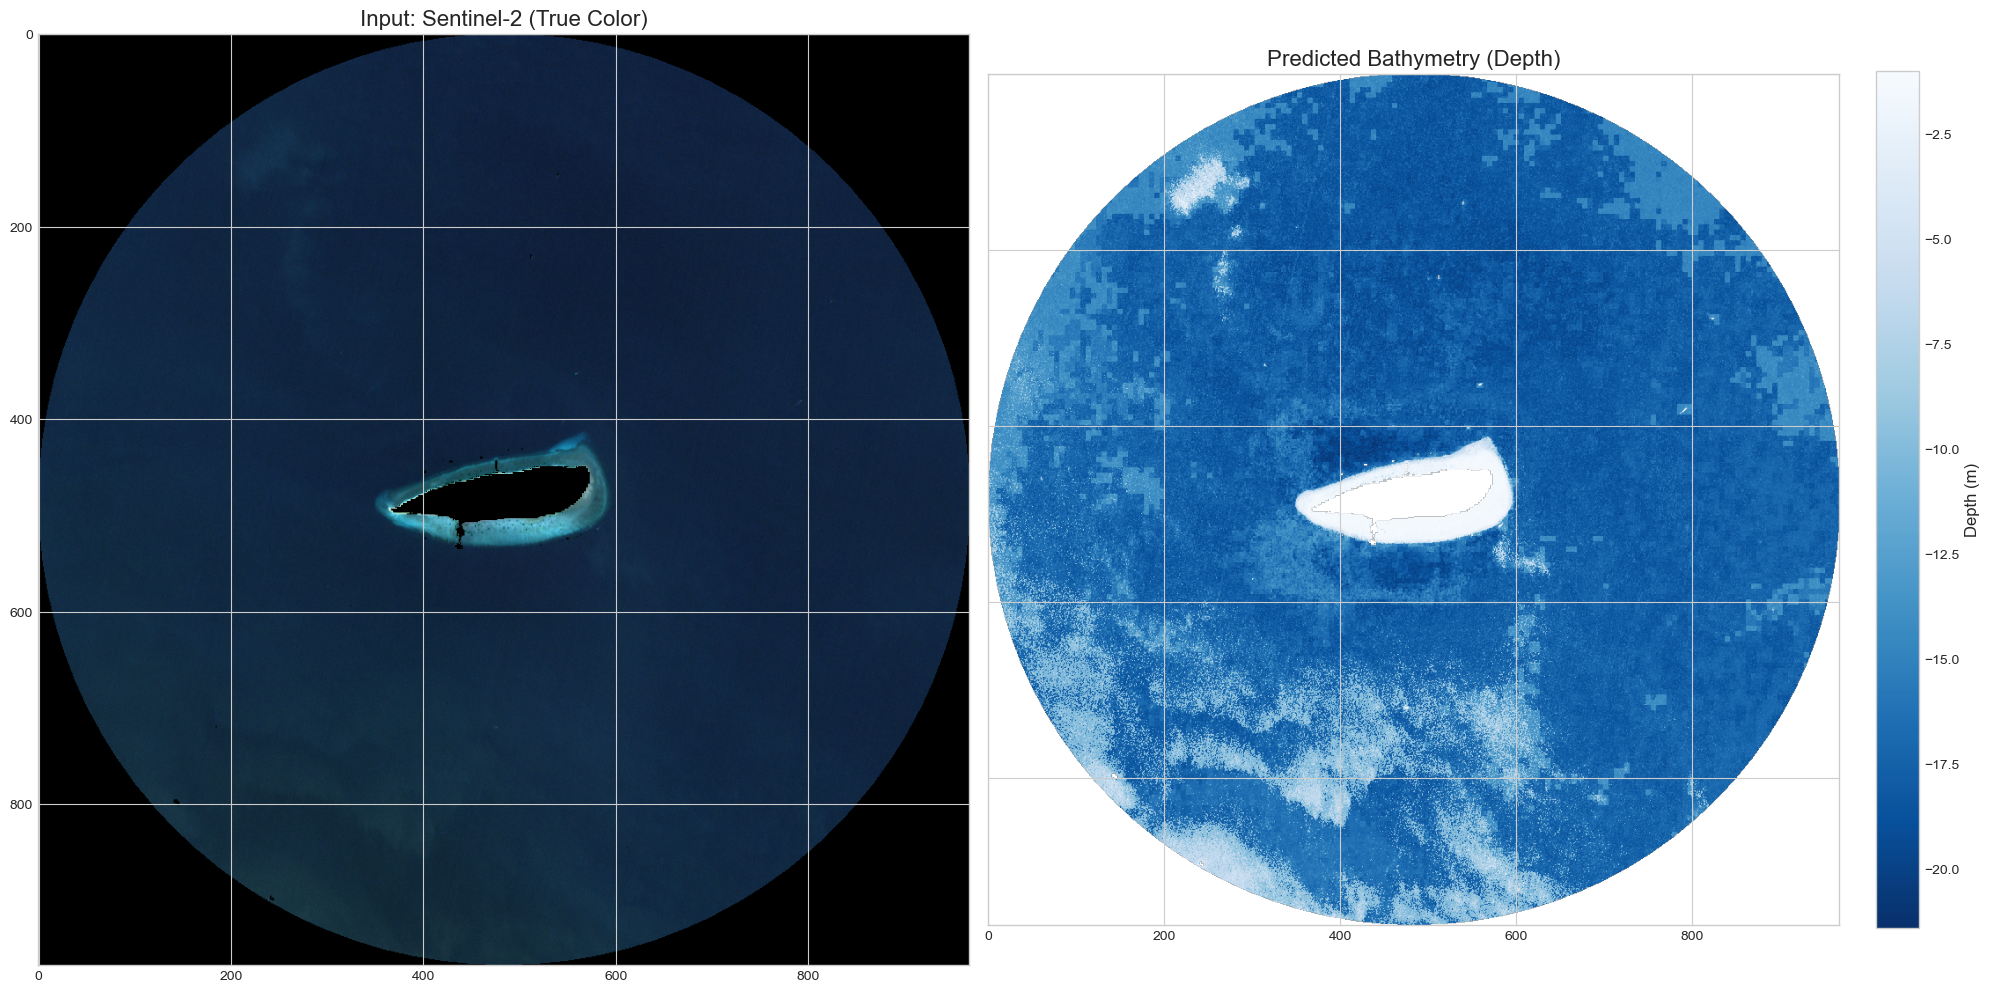

In [5]:
# ==========================================
# 5. EXPORT & VISUALIZE (ADAPTIVE)
# ==========================================

# --- A. Export to GeoTIFF ---
print("Exporting GeoTIFF...")

raster_meta.update({
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": 'float32',
    "compress": "lzw",
    "nodata": np.nan
})

full_output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

with rio.open(full_output_path, 'w', **raster_meta) as dst:
    dst.write(predicted_depth, 1)

print(f"Map saved to: {full_output_path}")

# --- B. Adaptive Visualization ---
print("\nGenerating Side-by-Side Map...")

def normalize(array):
    """Normalizes a numpy array to 0-1 range for plotting."""
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return (array - array_min) / (array_max - array_min)

# Detect Input Type based on Band Count
# Embeddings usually have 64 bands, Sentinel-2 (corrected) has ~12
is_embeddings = n_bands > 50 

if is_embeddings:
    # CASE 1: EMBEDDINGS (No RGB available)
    # Visualizing the first embedding dimension (A01) as structure reference
    print(f"Detected Embeddings ({n_bands} bands). Showing Feature A01 as reference.")
    input_image = normalize(raster_data[0, :, :]) # Band A01
    input_title = "Input: Embedding Feature A01 (Grayscale)"
    input_cmap = 'gray'
    is_rgb = False

else:
    # CASE 2: SENTINEL-2 (Try to create True Color)
    print(f"Detected Sentinel-2 ({n_bands} bands). Attempting RGB composite...")
    try:
        # Assuming standard ordering [B1, B2(Blue), B3(Green), B4(Red), ...]
        # Python Indices: B2=1, B3=2, B4=3
        if n_bands >= 4:
            red = normalize(raster_data[3, :, :])   # B4
            green = normalize(raster_data[2, :, :]) # B3
            blue = normalize(raster_data[1, :, :])  # B2
            input_image = np.dstack((red, green, blue))
            input_title = "Input: Sentinel-2 (True Color)"
            input_cmap = None
            is_rgb = True
        else:
            raise IndexError("Not enough bands for RGB")
            
    except Exception as e:
        # Fallback if bands are missing/different
        print(f"RGB creation failed ({e}). Showing Band 1.")
        input_image = normalize(raster_data[0, :, :])
        input_title = "Input: Band 1 (Grayscale)"
        input_cmap = 'gray'
        is_rgb = False

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Left Panel: Input Data
if is_rgb:
    axes[0].imshow(input_image)
else:
    axes[0].imshow(input_image, cmap=input_cmap)
    
axes[0].set_title(input_title, fontsize=16)
axes[0].axis('on')

# Right Panel: Predicted Depth
im = axes[1].imshow(predicted_depth, cmap='Blues_r')
axes[1].set_title("Predicted Bathymetry (Depth)", fontsize=16)
axes[1].axis('on')

# Colorbar
cbar = fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label("Depth (m)", fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'SDB_Gili_Ketapang_2018_s2.png'), dpi=300)
plt.show()